## Sentiment Analysis on movie reviews

This NLP project is aim to a classifiers for movie review scraped from IMDb.com:

1. Crawl data from IMDb.com, the top-100 most popular movies by genre (total 20 genres - Action, Adventure ...), refer to the website - https://www.imdb.com/chart/moviemeter?ref_=nv_mv_mpm_8 . The code of the spider is in the document "Movie-crawler".
2. Sentiment Analysis, build a classifier to predict the rating of a review, score from 1-10.

In [38]:
import numpy as np
import pandas as pd
import math
import re
import collections
import random
import string
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile, chi2

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [37]:
## input data
data_path = "Movie-crawler/IMDb/IMDb/spiders/reviews.csv"
origin_data = pd.read_csv(data_path)
origin_data = origin_data[np.isfinite(origin_data['rating'])]
origin_data = origin_data[pd.notnull(origin_data['review'])]
print(origin_data.shape)
corpus = origin_data.review.values
print(corpus[:5])
#y = np.array([0]*5331 + [1]*5331)

(12999, 4)
[ "Your going to be hard pressed to find a movie more over the top than Deadpool 2, David leitch takes it to a whole new level entirely. It works namely because the violence here is just to creative. Sure it defies all Logic most of the time, but i was laughing and having a rip-roaring time throughout.,Go into this movie knowing that it is a campy, corny, over the top superhero/action/comedy that is just about crazy shooting sequences and one-liners, and you'll be fine. Do not go into this movie expecting deep plot, meaningful conversations among characters, or anything remotely resembling a serious action or drama movie. ,Loved it...."
 "I was able to see Deadpool 2 at an advance screening. Deadpool shook things up and delivered offbeat fun when diehard fans were looking for something new from the genre. I thought it was a surprisingly well-rounded movie that perfectly encapsulated its hero and lovingly poked fun at both itself and other genre tropes. It was among my favour

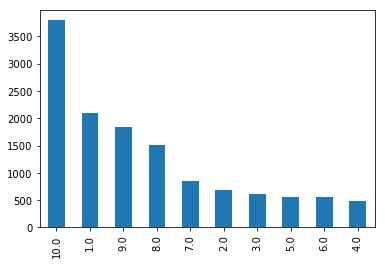

In [6]:
origin_data.rating.value_counts().plot("bar")

In [40]:
## Clean text

def clean_doc(text):
    
    text=text.lower()
    tokens = text.split()
    
    table = str.maketrans("","", string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [w for w in tokens if w.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

#    stemmer = SnowballStemmer('english')
#    tokens = [stemmer.stem(w) for w in tokens]
    
    tokens = [w for w in tokens if len(w) > 1]

    return tokens

clean_corpus = []
clean_words = []
for i, s in enumerate(corpus):
    clean_words.append(clean_doc(str(s)))
    clean_corpus.append(" ".join(clean_doc(s)))

print(clean_words[0])
print(clean_corpus[0])
print("Length of X:", len(clean_corpus))

['going', 'hard', 'pressed', 'find', 'movie', 'top', 'deadpool', 'david', 'leitch', 'takes', 'whole', 'new', 'level', 'entirely', 'works', 'namely', 'violence', 'creative', 'sure', 'defies', 'logic', 'time', 'laughing', 'riproaring', 'time', 'throughoutgo', 'movie', 'knowing', 'campy', 'corny', 'top', 'superheroactioncomedy', 'crazy', 'shooting', 'sequences', 'oneliners', 'youll', 'fine', 'go', 'movie', 'expecting', 'deep', 'plot', 'meaningful', 'conversations', 'among', 'characters', 'anything', 'remotely', 'resembling', 'serious', 'action', 'drama', 'movie', 'loved']
going hard pressed find movie top deadpool david leitch takes whole new level entirely works namely violence creative sure defies logic time laughing riproaring time throughoutgo movie knowing campy corny top superheroactioncomedy crazy shooting sequences oneliners youll fine go movie expecting deep plot meaningful conversations among characters anything remotely resembling serious action drama movie loved
Length of X: 1

In [ ]:
X = np.array(clean_corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

print("No. train-test samples:", y_train.shape[0], y_test.shape[0])

### Bag of words model

- tfidf + NaiveBayers
- tfidf + NeuralNet

In [ ]:
# text vectorization
vectorizer = TfidfVectorizer(max_df=0.9, decode_error='ignore', ngram_range=(1,2), stop_words="english")
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

print("After text vectorization,\ntraining set:", X_train_transformed.shape, 
      "\ntesting set:", X_test_transformed.shape)

## select 10% features based on chi2 stat
def reduce_dim(X_train, X_test, y_train, percentile):
    selector = SelectPercentile(chi2, percentile=percentile)
    selector.fit(X_train, y_train)
    X_train_reduced = selector.transform(X_train).toarray()
    X_test_reduced = selector.transform(X_test).toarray()
    return X_train_reduced, X_test_reduced

X_train_reduced, X_test_reduced = reduce_dim(X_train_transformed, 
                                             X_test_transformed, 
                                             y_train, percentile=10)

print("After dimension reduction,\ntraining set:", X_train_reduced.shape, 
      "\ntesting set:", X_test_reduced.shape)

In [ ]:
# model with Naive Bayes
clf = GaussianNB()
clf.fit(X_train_reduced, y_train)

print("Accuracy of train set: {:.2%}".format(clf.score(X_train_reduced, y_train)))
print("Accuracy of test set: {:.2%}".format(clf.score(X_test_reduced, y_test)))

In [ ]:
# model with neural netword (1 hidden-layer)
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
Xtrain = tokenizer.texts_to_matrix(X_train, mode='freq')
Xtest = tokenizer.texts_to_matrix(X_test, mode='freq')
ytrain = y_train
ytest = y_test

#print(Xtrain.shape, Xtest.shape)

n_words = Xtrain.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(n_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, ytrain, epochs=20, batch_size=64, verbose=2)
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

### Word embedding

- Train word embedding + PCA + visualization
- embedding + LSTM
- embedding + CNN + LSTM

In [ ]:
## train embedding with word2vec
from gensim.models import Word2Vec
import random

model = Word2Vec(clean_words, size=200, min_count=5)

In [ ]:
import scipy.spatial as sp

words = list(model.wv.vocab)
final_embeddings = model[model.wv.vocab]

similarity = 1 - sp.distance.cdist(final_embeddings, final_embeddings, 'cosine')
random_list = random.sample(range(len(words)), 10)
for i in random_list:
    top_sim = (-similarity[i,:]).argsort()[1:11]
    print("nearest neighbors of {0}: ".format(words[i]), end="")
    for k in top_sim:
        print(words[k], end=" ")
    print()

In [ ]:
from sklearn.decomposition import PCA

def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(12, 12))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

n_plot = 500
pca = PCA(n_components=2)
result = pca.fit_transform(final_embeddings[:n_plot, :])

labels = [words[i] for i in range(n_plot)]
plot_with_labels(result, labels)

In [ ]:
## build vocabulary

def count_data(all_words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:
      unk_count += 1
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return count, dictionary, reversed_dictionary

## words are indexed by overall frequency in the dataset, 
## so that for instance the integer "3" encodes the 3rd most frequent word in the data. 
def build_data(sep_words):
  data = list()
  for lst in clean_words:
    sent = list()
    for w in lst:
      if w in dictionary.keys():
        sent.append(dictionary[w])
      else:
        sent.append(dictionary["UNK"])
    data.append(sent)
  return data
    
count, dictionary, reverse_dictionary = build_dataset(all_words, vocab_size)
data = build_data(clean_words)
all_words = np.concatenate(clean_words)
vocab_size = 10000

print('Most common words (+UNK)', count[:10])
print("5 sample sentences:")
for i in range(5):
  if w in dictionary.keys():
    print([reverse_dictionary[j] for j in data[i]], data[i], sep="\n")
  else:
    print()

In [ ]:
## embedding + LSTM
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.preprocessing import sequence
np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=99, stratify=y)

vector_length = 100
sentence_length = 24

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

#print(X_train.shape, X_test.shape)
#print(X_train[:10])

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
## Embedding + LSTM + CNN
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
## long reviews from IMDb 
## load directly from keras
from keras.datasets import imdb

vocab_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

sentence_length = 500
embed_vecor_length = 32

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

model = Sequential()
model.add(Embedding(vocab_size, embed_vecor_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

## 2. Multi-class classification

In [ ]:
## import data
origin_data = pd.read_csv("data/kaggle.tsv", sep='\t')

X = origin_data["Phrase"].values
y = origin_data["Sentiment"].values

origin_data.head()

In [ ]:
pd.value_counts(y)

In [ ]:
def clean_sentence(text, rm_stopwords=True):
    """
    - Tokenize the words.
    - Remove all punctuation from words.
    - Remove all words that are not purely comprised of alphabetical characters.
    """
    
    text=text.lower()
    tokens = text.split()
    
    table = str.maketrans("","", string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [w for w in tokens if w.isalpha()]
    return tokens

clean_corpus = []
clean_words = []
for s in X:
    clean_words.append(clean_sentence(s))
    clean_corpus.append(" ".join(clean_sentence(s)))

print(clean_words[:10])
print(clean_corpus[:10])
print("Length of X:", len(clean_corpus))

In [ ]:
all_words = np.concatenate(clean_words)
count, dictionary, reverse_dictionary = build_dataset(all_words, vocab_size)
data = build_data(clean_words)
vocab_size = 10000

print('Most common words (+UNK)', count[:10])
print("5 sample sentences:")
for i in range(5):
  if w in dictionary.keys():
    print([reverse_dictionary[j] for j in data[i]], data[i], sep="\n")
  else:
    print()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=99, stratify=y)

sent_lens = [len(s) for s in clean_words]
sentence_length = np.round((np.mean(sent_lens) + 2*np.std(sent_lens))).astype(int)
vector_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

print("Shape of train-test data:", X_train.shape, X_test.shape)

Y_train = keras.utils.to_categorical(y_train, 5)
Y_test   = keras.utils.to_categorical(y_test, 5)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=32)
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
## An alternative way to train a word2vec with tensorflow

vocabulary_size = 1000
def build_dataset(words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

print("shape of batch:", batch.shape, "shape of labels:", labels.shape)

In [ ]:
batch_size = 64
embedding_size = 512  # Dimension of the embedding vector.
skip_window = 4  # How many words to consider left and right.
num_skips = 4  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample, used to adjust the weights.

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()
with graph.as_default():

  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/cpu:0'):
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(.1).minimize(loss)

  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                     valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  init = tf.global_variables_initializer()

In [ ]:
# training.
num_steps = 80001
with tf.Session(graph=graph) as session:
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    run_metadata = tf.RunMetadata()

    _, loss_val = session.run(
        [optimizer, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0
    
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

In [ ]:
def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(16, 16))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [ ]:
def doc2vec():
    vec = []
    for doc in corpus:
        vec_sum = np.zeros([embedding_size])
        for word in doc:
            if word not in dictionary:
                word = "UNK"
            vec_sum += final_embeddings[dictionary[word]]
        vec.append(vec_sum)
    return np.array(vec)


In [ ]:
X = doc2vec()
y = np.array([0]*5331 + [1]*5331)
print(X.shape, y.shape)